In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
graph_colors=np.array(list(mcolors.cnames.keys()))

In [4]:
orig_data=pd.read_csv("weatherAUS.csv")

## Hmm... The data seems confusing, and what features are to be clustered? Let's start analysis

In [ ]:
data.isna().sum()

#### Let's try and make sense of the data first

In [13]:
data[["Date","Rainfall"]].iloc[:3]# From kaggle- The amt of rainfall that day in mm

data["WindGustDir"].unique()#Okay Representing the strongest wind Direction here, honestly, it's maybe the first time 
                            #I have seen NNW-north north west

data["WindGustSpeed"].iloc[:3]#maybe mph or kmph

data["WindDir9am"].unique()

data["Humidity9am"].unique() #Percentage of Humidity in the Atmosphere

data["Pressure3pm"].head() #Pressure in HectoPascal (1 hpa=100 Pa) or millibar

data["Cloud3pm"].unique() 
#Apparently this is measured in some units called "okta" where 0 represents Completely Clear and it progressively increases to 
#8 which means completely cast. 9 means that the sky isn't visible to comment, maybe due to fog or smth(Source- Wikipedia)

data["Temp3pm"].head()#Temperature Measured in degrees Celsius

#The RainToday and RainTom are obvious. The only thing is that RainTom is the variable we need to predict

colors=data["RainTomorrow"]

colors.loc[colors=="No"]="Green"

colors[colors=="Yes"]="Red"

colors[colors.isna()]="Blue"

plt.scatter(np.arange(len(data["Rainfall"])),data['Rainfall'],c=colors)

## So Basically we need to think about the ways in which we can fill up the missing values
### Now being weather data, it would make much more sense if we were to replace the missing values with the average or the median of a week's given data, I mean month would be fine too, but the data across a week would be more consistent,accurate and better represent the given distribution


numeric_cols=[]
non_numeric_cols=[]
for col in data.columns:
    if(data[col].dtype in [float, int]):
        numeric_cols.append(col)
    else:
        non_numeric_cols.append(col)
#Yeah but in the non_numeric columns, we don't want to fill in for the RainTommorow and RainToday data, we have to predict that!
#So we do:
if(len(numeric_cols)>3):
    non_numeric_cols=non_numeric_cols[1:-2]

non_numeric_cols

### So Now that we have gotten the numeric and non-numeric dataset, what we are gonna do is that we are gonna fill null values in each numeric column with the mean/std of the week's numeric data.
### And in case of non-numeric data, we will fill them with the most occuring non-numeric variable in that week But again we can have missing data for an entire week, in which case our logic won't work, so it's best to replace the missing value with the most occuring among the nearest available values

data.isna().sum()

changed_data=data.copy()

def handle_columns(data):
    for col in numeric_cols:
        column=data[col]
        not_null_indices=np.argwhere(np.array(~column.isna())).squeeze(1)
        for i in range(len(not_null_indices)-1):
            ind=not_null_indices[i]
            ind2=not_null_indices[i+1]
            if((ind+1) != ind2):
                changed_data.loc[ind+1:ind2-1,col]=(column[ind]+column[ind2])/2
    print("Numeric Cols done")
    for col in non_numeric_cols:
        column=data[col]
        null_indices=np.argwhere(np.array(column.isna())).squeeze(1)
        for i in null_indices:
            index_to_pick=null_indices[i-7:i] #Picking the last 7 data points
            try:
                changed_data.loc[i,col]=column[index_to_pick].value_counts().index[0] #This gives is the value which has 
                #the maximum count in the past few days, this is in the try block coz the set of seven values that we are 
                #might all be null values in which case, we would just need to assign random non-numerical data
            except:
                changed_data.loc[i,col]=column.unique()[np.random.randint(len(column.unique()))]
        print("One Non Numeric Column Done")

handle_columns(data)

## Clearly Many Null Values have been removed but let's see how many in total

changed_data.isna().sum()

data.isna().sum()

## Some values have not been filled and the reason is clear, for numerical columns, the last indices haven't been filled coz there was no non-null value after them
## And apparently it has failed to fill in the null values for the non-numeric column when there were continous null values, so let's see what we can do for that

In [ ]:
changed_data["Evaporation"].isna().value_counts()

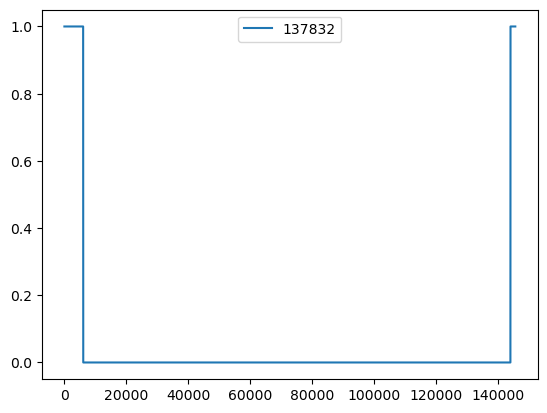

In [23]:
plt.plot(np.arange(len(changed_data["Evaporation"])),np.array(changed_data["Evaporation"].isna().astype(int)))
plt.legend(changed_data["Evaporation"].isna().value_counts())

In [24]:
changed_data["Date"]=pd.to_datetime(changed_data["Date"])

In [25]:
changed_data["Month"]=pd.Series(map(lambda x:x.month,changed_data["Date"]))

# Now let's check the distribution of null values in the Sunshine columns

Text(0, 0.5, '1: Null  0: Not Null')

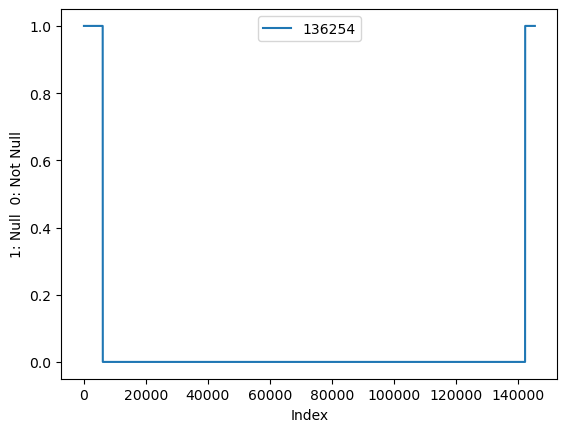

In [26]:
plt.plot(np.arange(len(changed_data["Sunshine"])),np.array(changed_data["Sunshine"].isna().astype(int)))
plt.legend(changed_data["Sunshine"].isna().value_counts())
plt.xlabel("Index")
plt.ylabel("1: Null  0: Not Null")

### Hence what we are gonna do is that we are gonna fill in the still missing numerical value with the mean of the values from that partcular month in all of the given data

In [27]:
for col in numeric_cols:
    avg=changed_data.groupby("Month")[col].mean()
    for month in range(1,13):
        fill_data=changed_data[changed_data["Month"]==month].loc[:,col].fillna(avg[month])
        changed_data.loc[fill_data.index,col]=fill_data.values

## Let's have a look then at the non-numeric column null value distribution

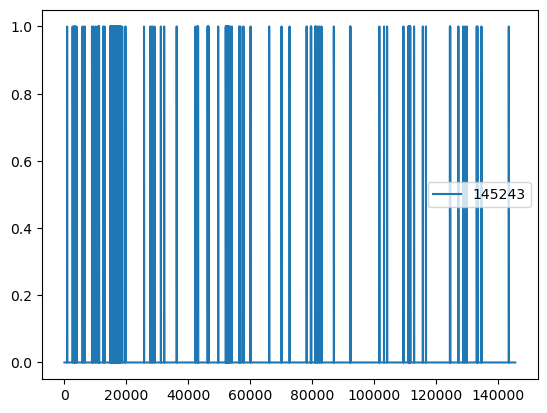

In [28]:
plt.plot(np.arange(len(changed_data["WindDir3pm"])),np.array(changed_data["WindDir3pm"].isna().astype(int)))
plt.legend(changed_data["WindDir3pm"].isna().value_counts())

## They aren't isolated like for Numerical Column, and It's hard for me to pin point where the Logic failed exactly. 
## So similar for numerical values I am gonna fill in the null values with the values whose frequency was highest during a "month"

In [ ]:
#THis gives is the month-wise data of the most occuring wind direction
[changed_data.groupby("Month").WindDir3pm.value_counts()[x].index[0] for x in range(1,13)]

In [30]:
#THis gives is the month-wise data of the most occuring wind direction
wind_dir=pd.Series(changed_data.groupby("Month").WindDir3pm.value_counts()[x].index[0] for x in range(1,13))

In [32]:
changed_data.drop("Date",axis=1,inplace=True)

In [33]:
for col in non_numeric_cols:
    null_indices=np.argwhere(np.array(changed_data[col].isna().astype(int))).squeeze(1)
    values_with_highest_freq_monthly=pd.Series(changed_data.groupby("Month")[col].value_counts()[x].index[0] for x in range(1,13))
    for idx in null_indices:
        mth=changed_data.loc[idx].Month
        changed_data.loc[idx,col]=values_with_highest_freq_monthly[mth-1]

In [ ]:
changed_data.isna().sum()#Alright, this eliminates the null values in the Non-Numerical Columns

### Alright, all sorts of Null values have been removed except the ones we have to predict obviously, let's go on now towards clustering

## Similar to Linear Regression, I have understood the concept but I have trouble doing it for multiple variables, so I am gonna do it for one variable first

In [35]:
x_input=changed_data["Rainfall"]
#Here the data either belongs to No rain or rain so only 2 clusters are present and by looking at the graph above, we can
#roughly estimate where the two centroids need to be
decision_clusters=np.array([np.array([40000,50]),np.array([100000,50])])

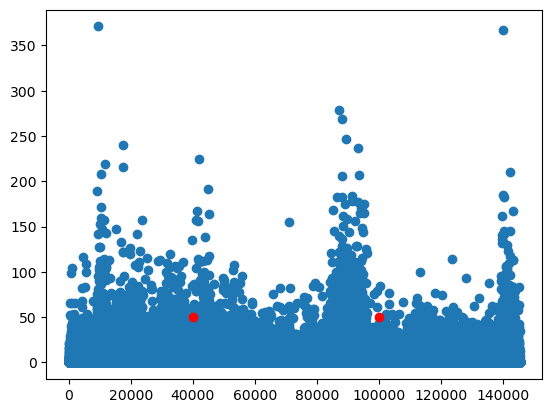

In [38]:
plt.scatter(range(len(x_input)),x_input)
plt.scatter(np.array([40000,100000]),np.array([50,50]),color="Red")

In [37]:
X=np.array(list(zip(x_input.index,x_input.values)))

In [40]:
first_dec_cluster=np.array([40000,50])
dist_from_first_cluster=np.linalg.norm(X-first_dec_cluster,axis=1)

sec_dec_cluster=np.array([100000,50])
dist_from_sec_cluster=np.linalg.norm(X-sec_dec_cluster,axis=1)

data_near_first_cluster=X[np.argwhere(dist_from_first_cluster<dist_from_sec_cluster).squeeze(1)]
data_near_sec_cluster=X[np.argwhere(dist_from_first_cluster>dist_from_sec_cluster).squeeze(1)]

##### Plotting the two clusters we obtained

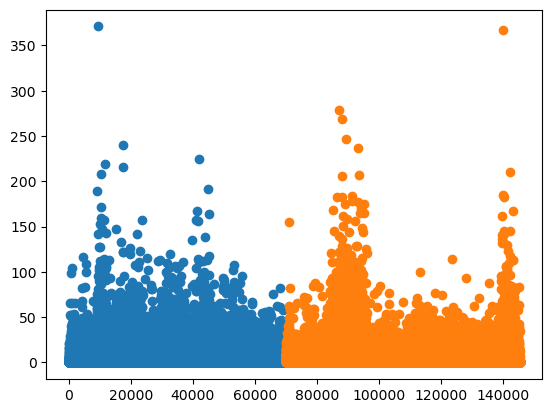

In [44]:
plt.scatter(data_near_first_cluster[:,0],data_near_first_cluster[:,-1])
plt.scatter(data_near_sec_cluster[:,0],data_near_sec_cluster[:,-1])

##### Now we need to update our chosen cluster points based on the mean of tha data falling in those two clusters

In [45]:
data_near_first_cluster[:,0].mean()  # mean of the  X-Coordinates of all the points belonging to the first cluster

data_near_first_cluster[:,1].mean()  #mean of the Y-Coordinates of all the poitns belonging to the first cluster

decision_clusters[0]=np.array([data_near_first_cluster[:,0].mean(),data_near_first_cluster[:,1].mean()])
decision_clusters[1]=np.array([data_near_sec_cluster[:,0].mean(),data_near_sec_cluster[:,1].mean()])

34999.5

## Writing the above process in a more organized way

DATA DISTRIBUTION BEFORE TRAINING:


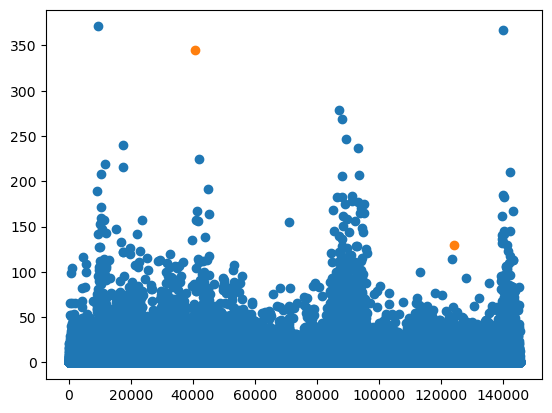

CLUSTER DIVISION:


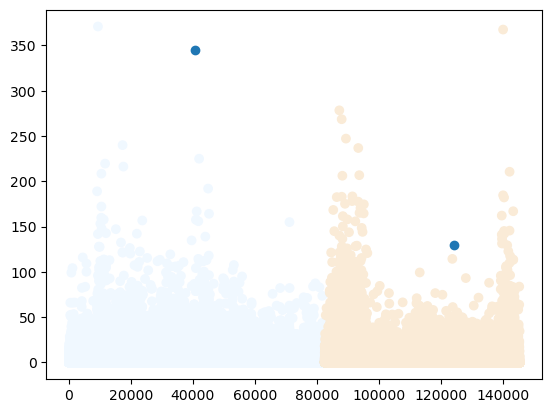

CLUSTER DIVISION:


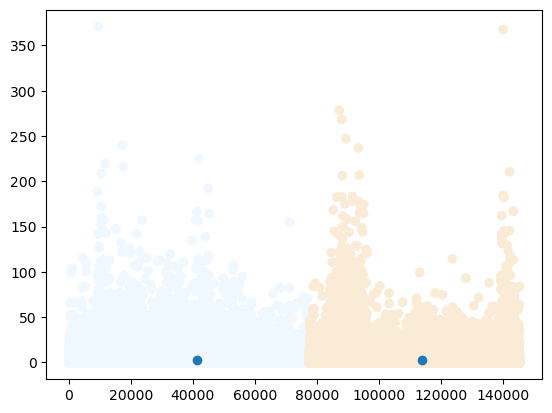

CLUSTER DIVISION:


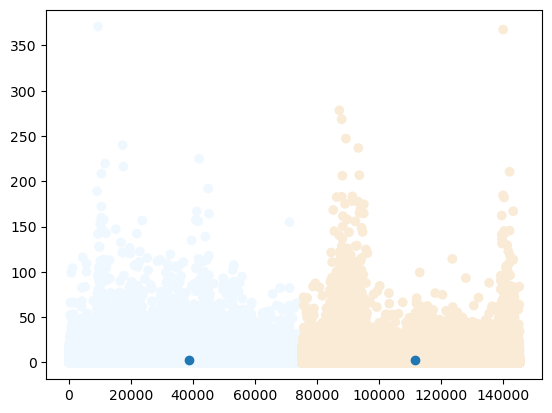

CLUSTER DIVISION:


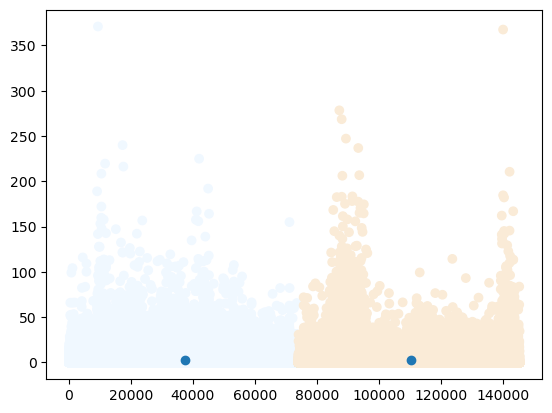

CLUSTER DIVISION:


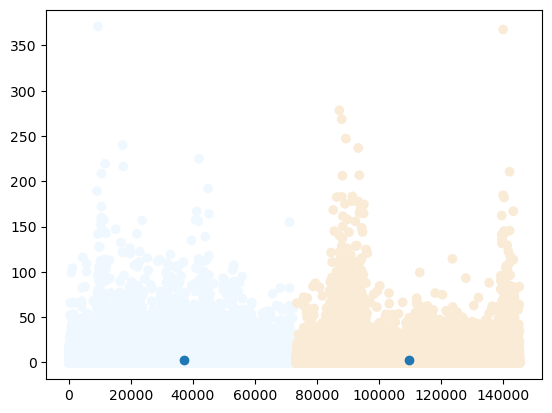

In [50]:
def K_means(X,n_clusters=5,epochs=10):
    X_input=np.array(list(zip(X.index,X.values)))
    num_samples=len(X)
    range_sample=X.max()-X.min()
    
    abcissa_cluster_points=np.array([np.random.randint(num_samples) for i in range(n_clusters)])
    ordinate_cluster_points=np.array([np.random.rand()*range_sample for i in range(n_clusters)])
    cluster_points=np.array(list(zip(abcissa_cluster_points,ordinate_cluster_points)))
    
    print("DATA DISTRIBUTION BEFORE TRAINING:")
    plt.scatter(range(num_samples),X.values)
    plt.scatter(abcissa_cluster_points,ordinate_cluster_points)
    plt.show()
    
    dist_from_cluster={}
    
    for epoch in range(epochs):
        for sample_num in range(len(X_input)):
            dist_from_cluster[sample_num]=np.linalg.norm(cluster_points-X_input[sample_num],axis=1)#This part gets the distance 
            #of each sample from all the clusters and the data is stored in the format below:
            """
            array([[1,2,3,4,5],
                   [7,8,9,10,11]])....
            where [1,2,3,4,5] represents the distance of the first sample from the five clusters(or n_clusters)       
            """
        #Then we are obtaining which cluster point is closest to that particular data point 
        cluster_label=np.argmin(np.array(list(dist_from_cluster.values())),axis=1)
        #Then we plot them
        print("CLUSTER DIVISION:")
        plt.scatter(X.index,X.values,c=graph_colors[:n_clusters][cluster_label])
        plt.scatter(abcissa_cluster_points,ordinate_cluster_points)
        plt.show()
     
        
        #We are creating a dataframe which contains the given input values and the corresponding cluster labels
        distri_dataframe=pd.DataFrame({"Data":X.values,"Cluster":cluster_label})
        for cluster in range(n_clusters):
            #We are obtaining the values that belong to a particular cluster by the below statement
            value_df=distri_dataframe[distri_dataframe["Cluster"]==cluster].drop("Cluster",axis=1)
            #Then we are updating the centroids, or cluster points
            abcissa_cluster_points[cluster]=np.mean(value_df.index) 
            ordinate_cluster_points[cluster]=value_df.mean().item()
            cluster_points=np.array(list(zip(abcissa_cluster_points,ordinate_cluster_points)))
            
        
K_means(changed_data["Rainfall"],n_clusters=2,epochs=5)

### Alright, so the algorithm seems to be working somewhat, and is spitting the data into two equal halves, but that's not what we have to do, we have to cluster them in two blobs that let give us a rough approximation of whether it's gonna rain tomorrow or not

### So I'm gonna try something, just like we did for one column, we are gonna calculate the distance of each cluster point from all the features present in our dataset, and then take the mean of that which will then decide which cluster does a particular feature belong to.

In [85]:
#Sample Centroid
cent=np.array([10000,40])
#First I'm gonna try only with numerical columns, Non-numerical is too much
num_data=changed_data[numeric_cols]

## Except the fact that I am stupid, if there are 24 features in total, it means the data is 24-dimensional (I've never felt closer to Sci-fi), which means that the centroids that we are gonna define should also be 24-D

### Also for the first step, I am gonna pick 2 clusters, although the number of cluster should vary depending on how well the different numbers can capture the variance in the data, but let's go with 2 first

In [52]:
def encode(unique_mapping,zeros,x):
    new_z=zeros.copy()
    new_z[unique_mapping[x]]=1
    return new_z

In [53]:
df=changed_data.copy()

In [54]:
#But first we need to do something with the non-numerical data
#We will one hot encode them to avoid any Biasing
for col in non_numeric_cols:
    l=len(df[col].unique())
    unique_index_mapping=dict(zip(df[col].unique(),range(len(df[col].unique()))))
    zeros=np.zeros(l)
    df[col]=pd.Series(list(map(lambda x:encode(unique_index_mapping,zeros,x),df[col])))

In [ ]:
#initialize the clusters
def init_clusters(num_features,num_clusters):
    return np.array([np.random.randn(num_features) for i in range(num_clusters)])

### I am dropping RainToday and RainTomorrow features because they are the values that we want to predict

In [57]:
df=df.drop(["RainTomorrow","RainToday"],axis=1)
num_clusters,num_features=2,df.columns.__len__()
cls=init_clusters(num_features,num_clusters)

In [60]:
df3=changed_data.copy()

In [61]:
for col in non_numeric_cols:
    column=df3[col]
    value_mapping=dict(zip(column.unique(),range(len(column.unique()))))
    df3[col]=pd.Series(map(lambda x:value_mapping[x],column))

In [64]:
df3=df3.drop(["RainToday","RainTomorrow"],axis=1)
df3=df3.astype(np.float64)

In [69]:
def KMeans_multiple(data,epochs,num_clusters,num_features):
    cls=init_clusters(num_features,num_clusters)
    dist_from_cluster=np.array([np.random.randn(len(data))])
    cluster_labels=None
    for epoch in range(epochs):
        for idx in range(len(cls)):
            dist_from_cluster=np.insert(dist_from_cluster,-1,np.linalg.norm(data-cls[idx],axis=1),axis=0)
        dist_from_cluster=np.delete(dist_from_cluster,-1,axis=0)
        cluster_labels=np.argmin(dist_from_cluster.T,axis=1)
        
        for idx in range(len(cls)):
            data_assigned_to_that_cluster = np.argwhere(cluster_labels==idx).squeeze(1)
            cls[idx] += data.iloc[data_assigned_to_that_cluster].mean()
        dist_from_cluster=np.array([np.random.randn(len(data))])
    return cluster_labels


cluster_labels=KMeans_multiple(df3,100,4,len(df3.columns))
            

In [70]:
set(cluster_labels)

{0}

## Hmm... all of them clustering towards a single data point, I want to try something, K means only with the numeric columns

In [169]:
cluster_labels=KMeans_multiple(df3[numeric_cols],100,4,len(numeric_cols))
#Didn't make a difference

## Alright so I guess the major problem is with the cluster initialization step, will have to make it better.
### I just read a silly piece of information, that the centroids are mostly initialized from the data points themselves, not randomly, the centroids are randomly selected from the dataset itself

In [72]:
def init_clusters(num_clusters):
    return np.array(df3.iloc[[np.random.randint(len(df3)) for x in range(num_clusters)]])

In [73]:
cls=init_clusters(num_clusters)

In [97]:
def KMeans_multiple(data,epochs,num_clusters,num_features,centroids):
    dist_from_cluster=np.array([np.random.randn(len(data))])
    cluster_labels=None
    for epoch in range(epochs):
        for idx in range(len(centroids)):
            dist_from_cluster=np.insert(dist_from_cluster,-1,np.linalg.norm(data-centroids[idx],axis=1),axis=0)
        dist_from_cluster=np.delete(dist_from_cluster,-1,axis=0)
        cluster_labels=np.argmin(dist_from_cluster.T,axis=1)
        
        for idx in range(len(centroids)):
            data_assigned_to_that_cluster = np.argwhere(cluster_labels==idx).squeeze(1)
            centroids[idx] += data.iloc[data_assigned_to_that_cluster].mean().values
        dist_from_cluster=np.array([np.random.randn(len(data))])
    return cluster_labels,centroids


cluster_labels=KMeans_multiple(Aus,1,4,len(Aus.columns),cls)
#When the number of epochs is increased, they all cluster towards the same cluster

### Okay okay, here they atleast converge towards multiple centroids, but again, if we are increasing the number of epochs, they start to converge more towards one also that is completely dependent upon the way they are initialized, so we gotta change the centroid initialization in some way.

## Some googling tells me of a different method in which we can initialize the centroids, called the KMeans ++ algo.

### Now here's what the Kmeans++ does : It Picks the first centroid randomly from the dataset itself. And then it picks that data point as the centroid which is farthest from it.
### After this, it assigns each data point to it's nearest centroid, and then again of all the clusters formed, the point in any cluster that is the farthest from it's data point is picked as the centroid.

In [91]:
def init_centroids(n_cent,data):
    centroids = [data.iloc[np.random.randint(len(data))].values]
    for _ in range(n_cent):
        dist_from_centroids = [np.linalg.norm(data-cent,axis=1) for cent in centroids]
        dist_from_centroids = np.max(dist_from_centroids,axis=0)
        dist_from_centroids/= np.sum(dist_from_centroids) #We need to Normalize the distances so that we can consider them as 
        #probabilities, and probabilities should add up to zero
        new_cent_idx = np.random.choice(range(len(data)),size=1,p=dist_from_centroids)
        centroids+= [data.iloc[new_cent_idx[0]].values]
    return centroids

## Alright, seems to initiliaze centroids, let's put it to work

In [88]:
centroids=init_centroids(4,df3)

In [89]:
cluster_labels , updated_centroids=KMeans_multiple(df3,1,4,len(df3.columns),centroids)
set(cluster_labels)

{0, 1, 2, 3, 4}

### Oh my Word!!! It works!!! Holy Moly!! Or atleast it the data is getting properly distributed now
#### Let's try and get a sense of how well is the clustering done using the sillouhette score. Now what the sillouhetter score basically measures is how similar the samples in a cluster are to other samples in the same cluster, which gives us a rough idea of how good the clustering is

In [107]:
from sklearn.metrics import silhouette_score
silhouette_score(df3,cluster_labels)

## The silouhete score basically measures how well distinguished the clusters are and ranges from -1 to 1. A score of 1 suggests that the clusters are very well distinguished, 0 indicates that the clusters are ambigous, while -1 indicates that the clustering is not proper at all. 

### So one of the reason why the score could be poor is because of the number of clusters chosen, let's look into better ways of doing that


# Elbow Method :
#### In this, we perform K-Means multiple times over a given sample for different values of k(mostly ranging from 1-10) and then plot the "inertia" or "wcss" for each k 
#### Now, "inertia" or "wcss" simply refers to the sum of squares of distances of the samples from their nearest cluster points

In [101]:
 def get_elbow(data = None,num_k = 10):
    for itr in range(10):
        inertia = []
        for num_centroids in range(1,num_k):
            centroids=init_centroids(num_centroids,data)
            cluster_labels , updated_centroids=KMeans_multiple(data,1,4,len(data.columns),centroids)
            wcss = 0
            for idx,sample in zip(cluster_labels,data.values):
                wcss += np.linalg.norm(sample-centroids[idx])**2
            inertia.append(wcss)
        plt.plot(range(1,num_k),inertia)
        plt.show()

## Alright, the dip is very confusing but I am gonna use k=3,4,6

In [109]:
for k in range(3,7):
    centroids=init_centroids(4,df3)
    cluster_labels , updated_centroids=KMeans_multiple(df3,1,4,len(df3.columns),centroids)
    print(silhouette_score(df3,cluster_labels))
    

0.04105134381571765
0.10040677419863128
0.04548448314506069
0.023718106867165176


## Alright, let me use sklearn as a baseline

In [110]:
from sklearn.cluster import KMeans
cls = KMeans()

In [115]:
silhouette_score(df3,KMeans().fit_predict(df3))

C:\Users\okher\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.13882805469505716

## Viola!! The pre-built model is doing the same as mine, which means atleast my architecture is good, there might be some error in the way I have handled null values

### What if completely drop the null values and test my model on that? Just for validation

In [206]:
data_trimmed = data.dropna()
len(data),len(data_trimmed) #Hugeeee Decrease in the number of samples let's evaluate my model on this

(145460, 56420)

In [ ]:
for col in non_numeric_cols+["RainToday","RainTomorrow"]:
    column=data_trimmed[col]
    value_mapping=dict(zip(column.unique(),range(len(column.unique()))))
    data_trimmed.loc[:,col] = pd.Series(map(lambda x:value_mapping[x],column)).isna().sum()

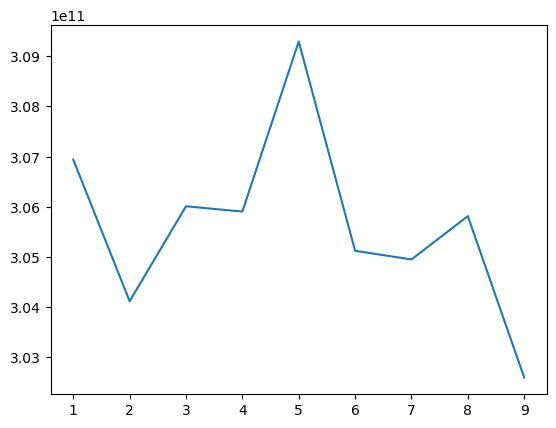

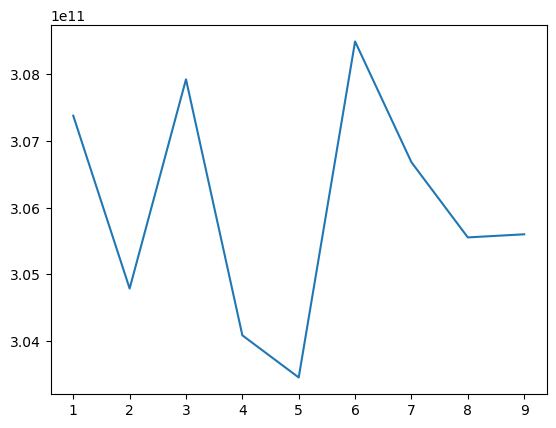

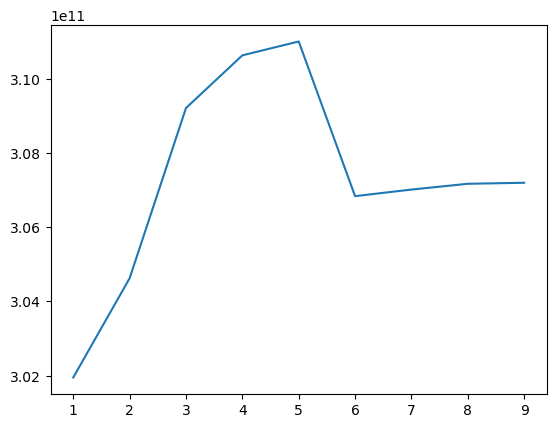

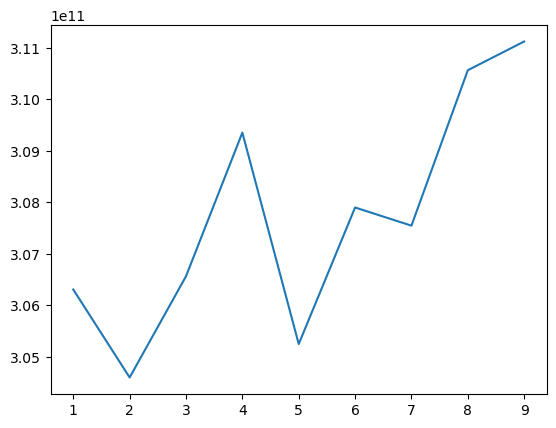

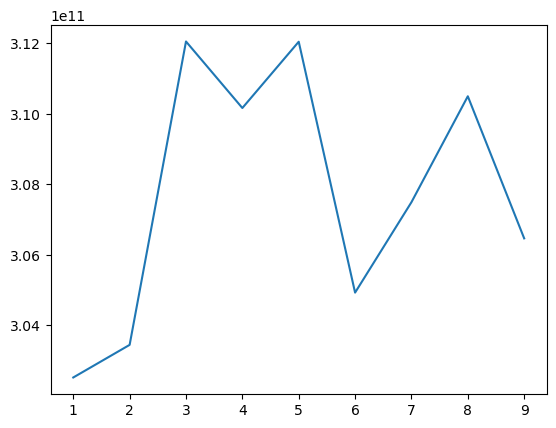

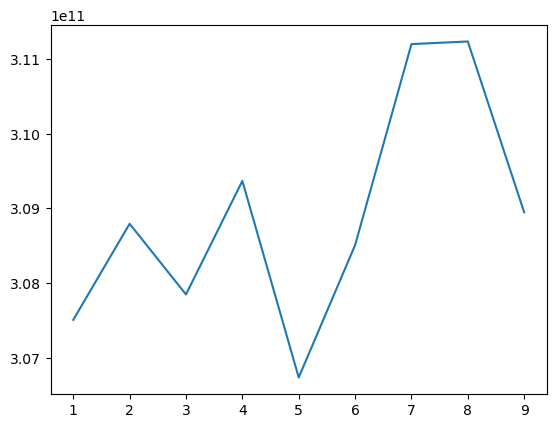

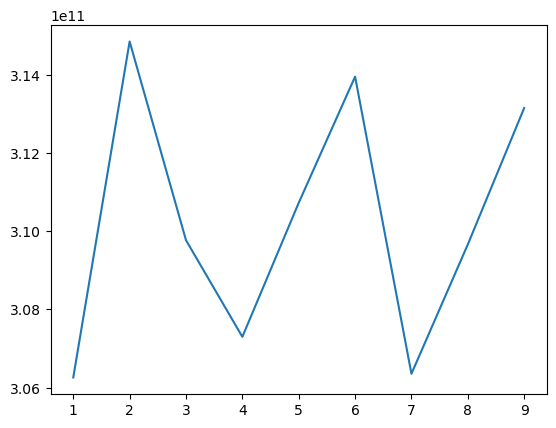

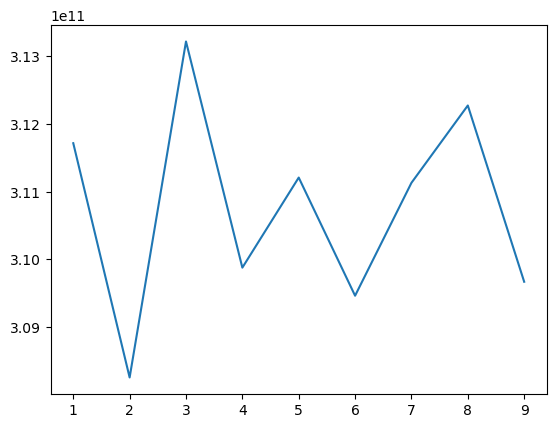

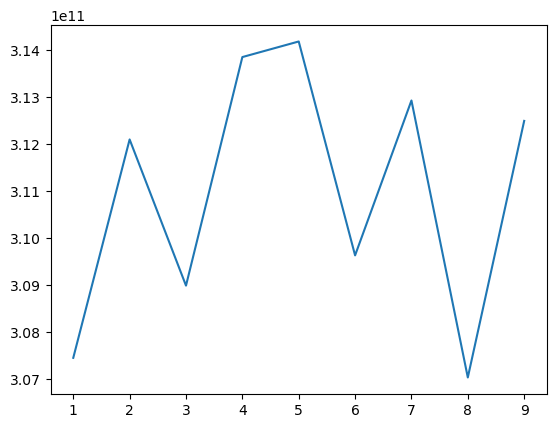

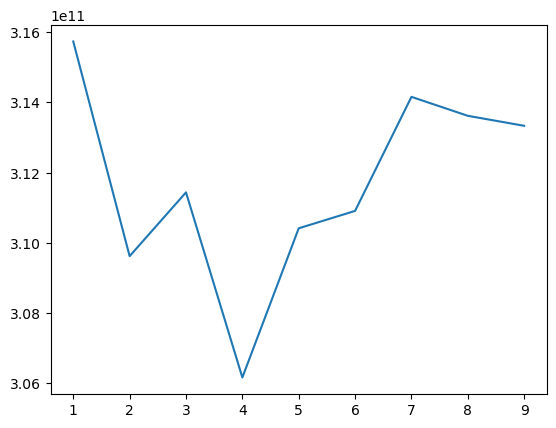

In [144]:
get_elbow(data_trimmed_scaled)

In [ ]:
data_trimmed.drop("Date",axis=1,inplace=True)

In [212]:
centroids=init_centroids(5,data_trimmed)
cluster_labels , updated_centroids=KMeans_multiple(data_trimmed,1,4,len(data_trimmed.columns),centroids)
print(silhouette_score(data_trimmed,cluster_labels))

0.1544816868026528


#### Now it's time to Visualize the cluster labels using PCA

## Q. Would I be right If I said that for PCA, the choice of axis can also be thought of as how many data points each Principal Component or axis passes through?

In [297]:
#Alright so we have the centroids as follows
updated_centroids=np.array(updated_centroids)

In [299]:
#First PCA requires us to center the data
updated_centroids = updated_centroids - updated_centroids.mean(axis=0)
U, s, Vt = np.linalg.svd(updated_centroids)
PC1= Vt.T[:,0]
PC2= Vt.T[:,1]

#### Now although SVD(Singular Value Decomposition) Breaks down the given data into the as many Principal Components as there are dimensions, we need only the first n-dimensions in order to reduce the dimensions to n.
##### Since here we're reducing it to 2, we only consider the first 2 principal components

In [302]:
W2 = Vt.T[:, :2]
updated_centroids_in_2D = updated_centroids.dot(W2)`

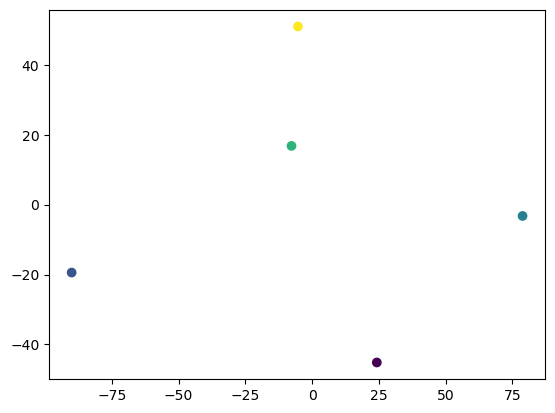

In [314]:
plt.scatter(updated_centroids_in_2D[:,0],updated_centroids_in_2D[:,1],c=updated_centroids_in_2D[:,1])

## We can also plot the data and see if they actually fall into these clusters, let's do PCA on the whole data

In [319]:
data_centred=df3-df3.mean(axis=0)
U_, s_, Vt_ = np.linalg.svd(updated_centroids)
PC1= Vt_.T[:,0]
PC2= Vt_.T[:,1]
W2 = Vt_.T[:, :2]
data_in_2D = data_centred.dot(W2)

### Umm.. I guess some outliers are causing the graph to look weird, let's get rid of them for the sake of plotting

(-100.0, 200.0)

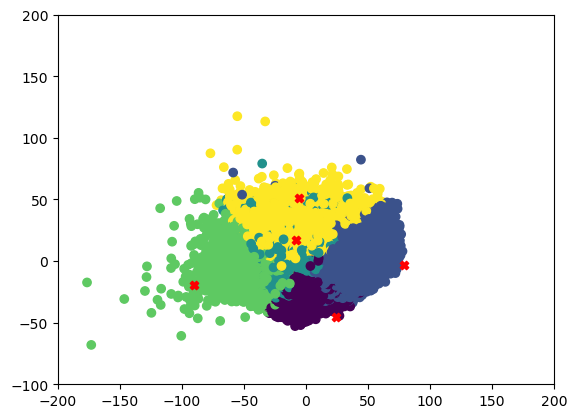

In [337]:
plt.scatter(data_in_2D[0],data_in_2D[1],c=cluster_labels)
plt.scatter(updated_centroids_in_2D[:,0],updated_centroids_in_2D[:,1],c='r',marker='X')
plt.xlim((-200,200))
plt.ylim((-100,200))

## Hmm.. Not the best results,seems like we'll have to try a better method for centroid initialization

## Working on it again

In [43]:
Aus = orig_data.copy()

### Date Column: Let's extract day;month;year coz being weather data, we are sure to find some cyclic pattern

In [44]:
Aus["Date"]=pd.to_datetime(Aus["Date"])
Aus["Month"]=pd.Series(map(lambda x:x.month,Aus["Date"]))
Aus["Year"]=pd.Series(map(lambda x:x.year,Aus["Date"]))
Aus["Day"]=pd.Series(map(lambda x:x.day,Aus["Date"]))

### Location Column, instead of simply encoding them with numbers, we can choose to represent them using latittudes and longitudes

In [45]:
lat_lon_dict = {
    'Adelaide':(-34.9281805,138.5999312),'Albany':(41.000028,19.9999619),'Albury':(-36.0737304,146.9135396),
    'AliceSprings':(-23.6983884,133.8812885),'BadgerysCreek':(-33.8816671,150.7441627),'Ballarat':(-37.5623025,143.8605649),
    'Bendigo':(-36.7588767,144.2825931),'Brisbane':(-27.4689682,153.0234991),'Cairns':(-16.9206657,145.7721854),
    'Canberra':(-35.2975906,149.1012676),'Cobar':(-31.4983333,145.8344444),'CoffsHarbour':(-30.2986319,153.1227414),
    'Dartmoor':(50.5657372,-3.90097323715792),'Darwin':(-12.46044,130.8410469),'GoldCoast':(-28.0023731,153.4145987),
    'Hobart':(-42.8825088,147.3281233),'Katherine':(-14.4646157,132.2635993),'Launceston':(-41.4340813,147.1373496),
    'Melbourne':(-37.8142454,144.9631732),'MelbourneAirport':(-37.66695115,144.83348479329175),
    'Mildura':(-34.195274,142.1503146),'Moree':(47.9015941,1.2378026),'MountGambier':(-37.8246698,140.7820067624113),
    'MountGinini':(-35.5297437,148.7725396),'Newcastle':(54.9738474,-1.6131572),'Nhil':(53.5536418,10.0098056),
    'NorahHead':(-33.2816667,151.5677778),'NorfolkIsland':(-29.0328038,167.9483137),'Nuriootpa':(-34.4693354,138.9939006),
    'PearceRAAF':(-31.6739604,116.01754351808195),'Penrith':(54.6649465,-2.749059585987326),
    'Perth':(-31.9558933,115.8605855),'PerthAirport':(-31.9406095,115.96760765137932),'Portland':(45.5202471,-122.674194),
    'Richmond':(37.5385087,-77.43428),'Sale':(44.980656,8.809348),'SalmonGums':(-32.9815347,121.6439417),
    'Sydney':(-33.8698439,151.2082848),'SydneyAirport':(-33.935309,151.1655825),'Townsville':(-19.2569391,146.8239537),
    'Tuggeranong':(-35.4209771,149.0921341),'Uluru':(-25.3455545,131.03696147470208),
    'WaggaWagga':(-35.115,147.3677778),'Walpole':(42.1417653,-71.2494985),'Watsonia':(-37.7110022,145.083635),
    'Williamtown':(-32.815,151.8427778),'Witchcliffe':(-34.0263348,115.1004768),'Wollongong':(-34.4278083,150.893054),
    'Woomera':(-31.1999142,136.8253532)}
#Source: Kaggle

In [46]:
Aus["Latitude"]=Aus["Location"].map(lambda loc:lat_lon_dict[loc][0])
Aus["Longitude"]=Aus["Location"].map(lambda loc:lat_lon_dict[loc][1])

## Now, some googling tells me that before filling in the null values, I have to check the state of outliers in the dataset, if it contains a lot of outliers, then "median" is the best option to fill null values or else "mean"

### Now the reason choosing median doesn't hurt in case of outliers is that it doesn't actually depend on the value of the extremes, but by there position in the dataset when they have been arranged in ascending order to find the median.

In [47]:
numeric_cols = []
non_numeric_cols = []
for col in data.columns:
    if(data[col].dtype in [float, int]):
        numeric_cols.append(col)
    else:
        non_numeric_cols.append(col)

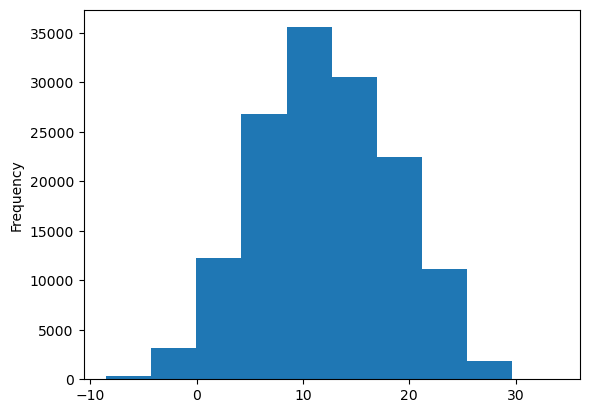

Plotting against: MinTemp


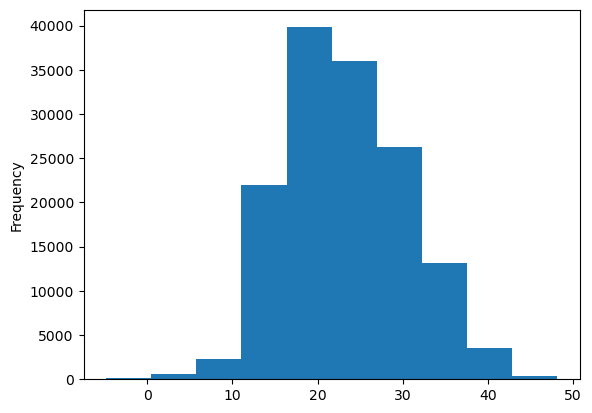

Plotting against: MaxTemp


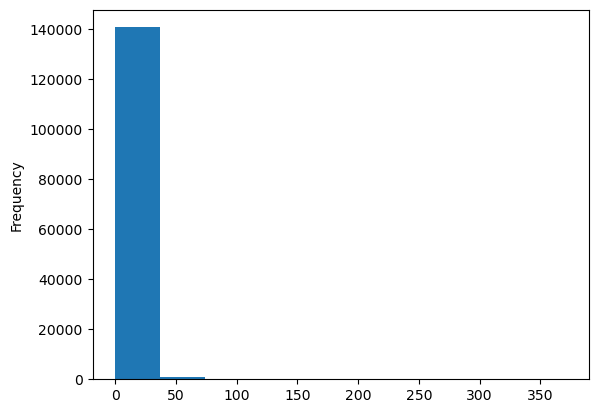

Plotting against: Rainfall


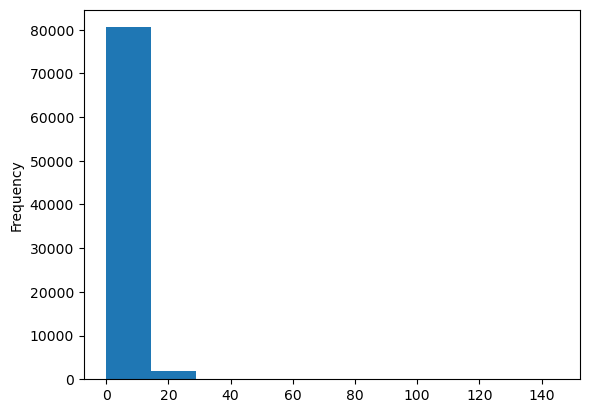

Plotting against: Evaporation


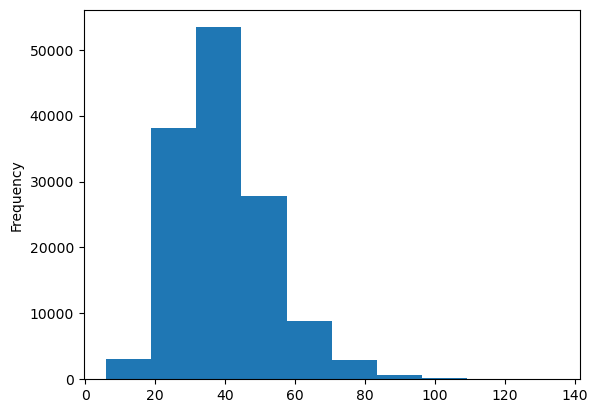

Plotting against: WindGustSpeed


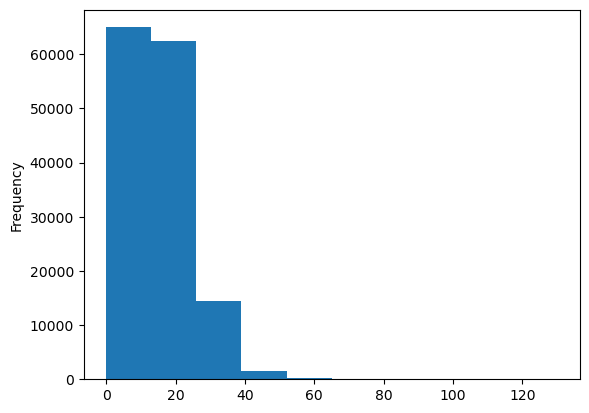

Plotting against: WindSpeed9am


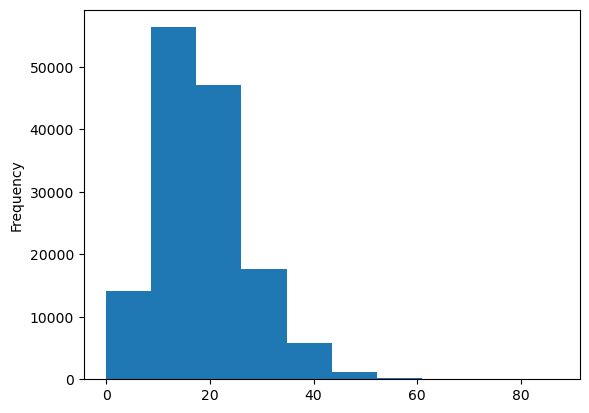

Plotting against: WindSpeed3pm


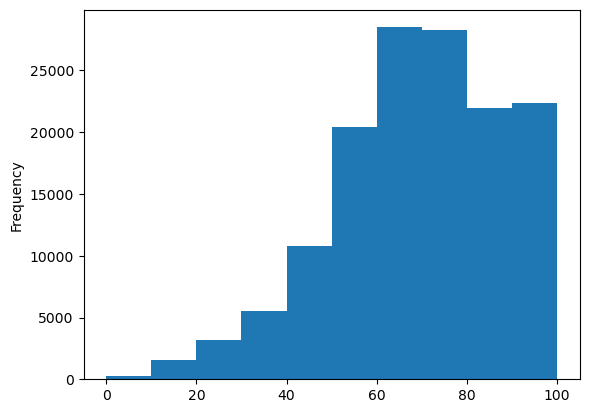

Plotting against: Humidity9am


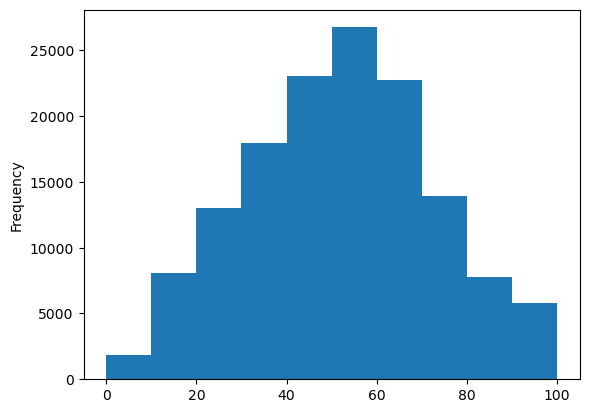

Plotting against: Humidity3pm


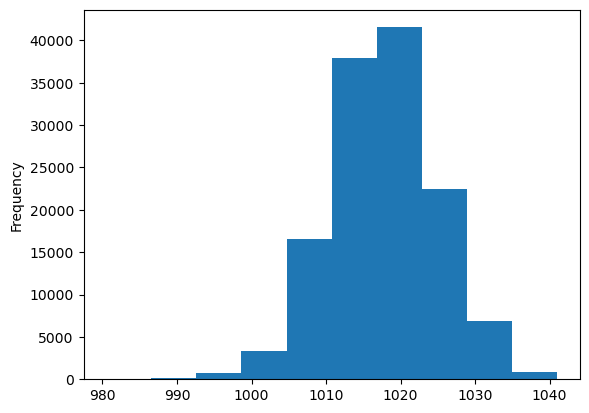

Plotting against: Pressure9am


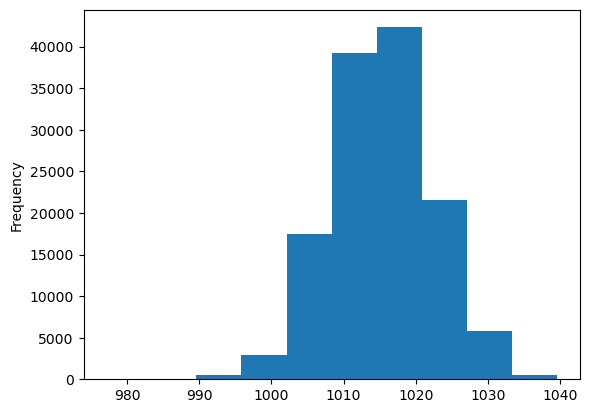

Plotting against: Pressure3pm


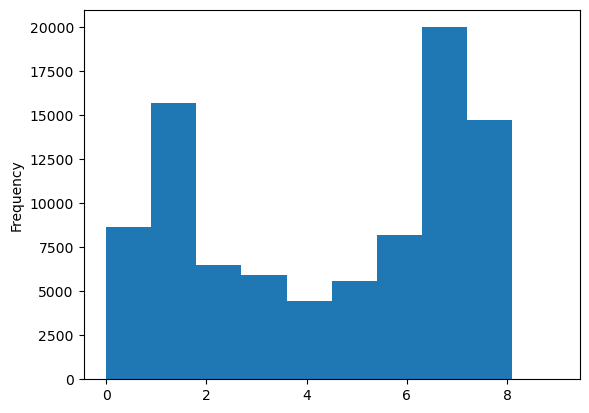

Plotting against: Cloud9am


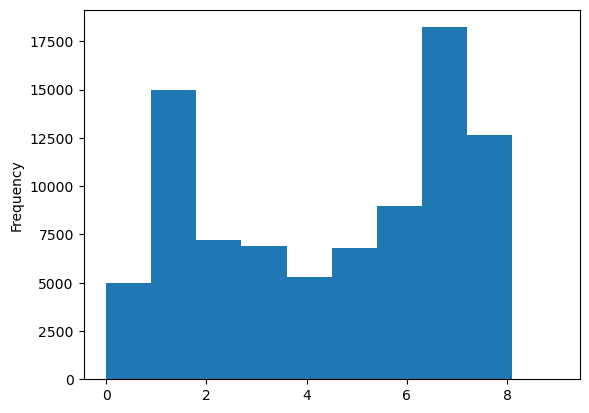

Plotting against: Cloud3pm


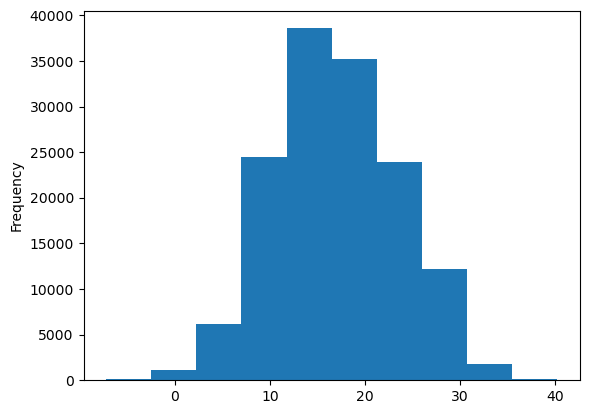

Plotting against: Temp9am


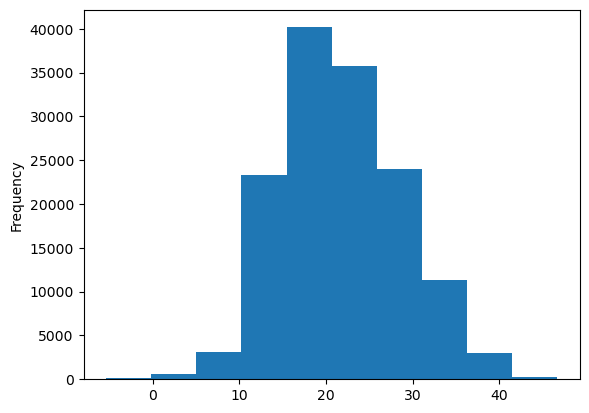

Plotting against: Temp3pm


In [48]:
for col in numeric_cols:
    Aus[col].plot(kind="hist")
    plt.show()
    print("Plotting against:",col)

### Alright so the histograms show that most of the features donot follow the bell curve, hence are skewed to a large extent due to outliers, so a better option to fill null values would be median

### MinTemp | MaxTemp | Temp9am | Temp3pm

In [49]:
temp_cols = ["MinTemp","MaxTemp","Temp9am","Temp3pm"]
Aus[["MinTemp","MaxTemp","Temp9am","Temp3pm"]].isna().sum()#Checking the number of null values
for col in temp_cols:
    Aus[col].fillna(data[col].median(),inplace=True)

In [50]:
#I will fill the null values with the median of the week's data in which they lie in
temp_cols = ["MinTemp","MaxTemp","Temp9am","Temp3pm"]
for col in temp_cols:
    column=Aus[col].loc[:]
    for i in range(0,len(column),7):
        column.loc[i:i+7]=column.loc[i:i+7].fillna(column.loc[i:i+7].median())
    Aus[col]=column

In [51]:
Aus[temp_cols].corr()

,MinTemp,MaxTemp,Temp9am,Temp3pm
MinTemp,1.000000,0.733358,0.897829,0.698574
MaxTemp,0.733358,1.000000,0.879335,0.968332
Temp9am,0.897829,0.879335,1.000000,0.845622
Temp3pm,0.698574,0.968332,0.845622,1.000000


<Axes: >

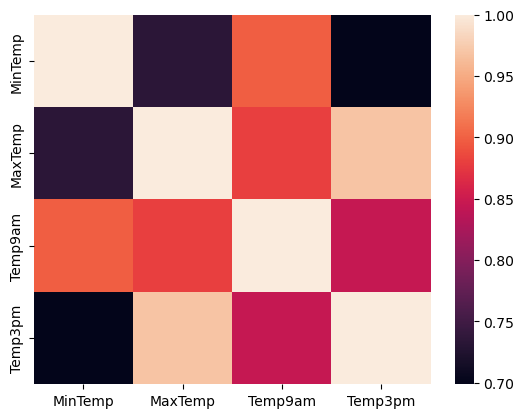

In [52]:
sns.heatmap(Aus[temp_cols].corr())

### Temp3pm and MaxTemp are very heavily Correlated, so I'm dropping one

In [53]:
Aus.drop("Temp3pm",axis=1,inplace=True)

### Rainfall

In [281]:
Aus["Rainfall"].fillna(Aus["Rainfall"].median,inplace=True)# This was done when we were not considering week to week 
#data

In [54]:
column=Aus["Rainfall"].loc[:]
for i in range(0,len(column),7):
    column.loc[i:i+7]=column.loc[i:i+7].fillna(column.loc[i:i+7].median())
Aus["Rainfall"]=column

### Evaporation

In [55]:
#Looking for outliers
df=Aus[["Evaporation","RainTomorrow","Month"]].dropna()

<Axes: xlabel='Evaporation', ylabel='RainTomorrow'>

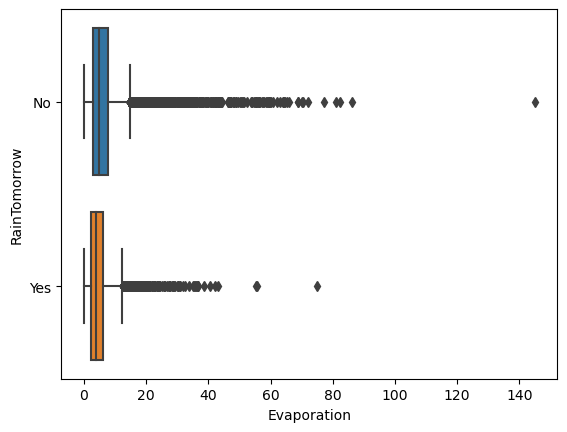

In [56]:
import seaborn as sns
sns.boxplot(df,x="Evaporation",y="RainTomorrow")#There are thousands of Outliers!!

In [57]:
#Let us look at the Monthly variations of Evaporation data
X=Aus["Month"]
Y=Aus["Evaporation"]

In [58]:
X_train=np.array(X[~ Y.isna()]).reshape(-1,1)
Y_train=np.array(Y.dropna())

## We get a nice Concave curve which definitely indicates a relationship between the month and the evaporation, so what I am gonna do is fill that missing value in a month by the median of that month, as again there are some outliers

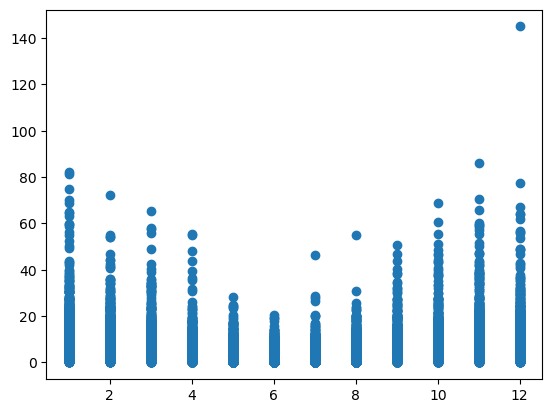

In [59]:
plt.scatter(X_train.reshape(82670),Y_train)

In [60]:
for month in Aus["Month"].unique():
    slc=Aus[Aus["Month"]==month]["Evaporation"].copy()
    slc=slc.median()
    idx = Aus[Aus["Month"]==month].loc[:,"Evaporation"].index
    Aus.loc[idx,"Evaporation"] = Aus.loc[idx,"Evaporation"].fillna(slc)

In [40]:
Aus["Evaporation"].fillna(Aus["Evaporation"].median,inplace=True)#This was used when we didn't consider the monthly variations

### Sunshine

In [42]:
Aus["Sunshine"].fillna(data["Sunshine"].median,inplace=True) #THis was done when we didn't considet the monthly variations

In [61]:
for month in Aus["Month"].unique():
    slc=Aus[Aus["Month"]==month]["Sunshine"].copy()
    slc=slc.median()
    idx = Aus[Aus["Month"]==month].loc[:,"Sunshine"].index
    Aus.loc[idx,"Sunshine"] = Aus.loc[idx,"Sunshine"].fillna(slc)

### Wind Gust Speed

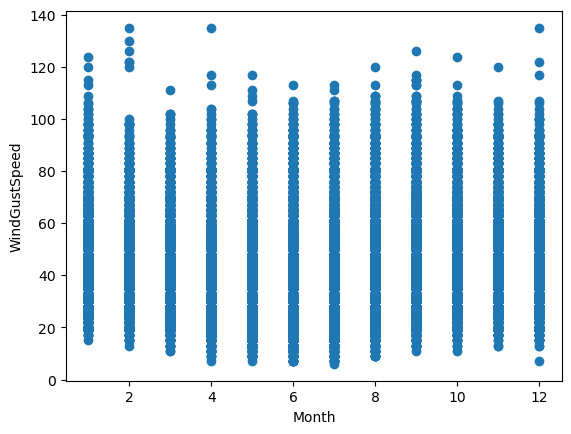

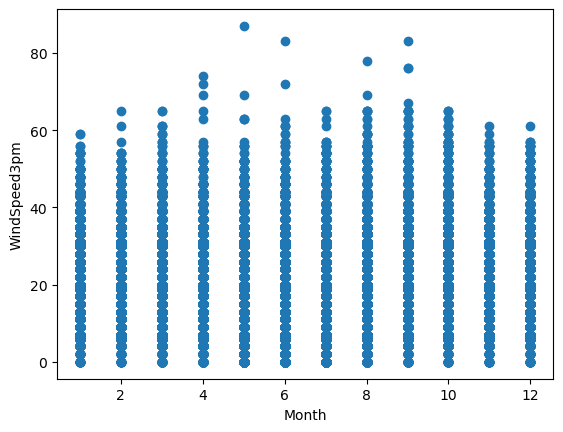

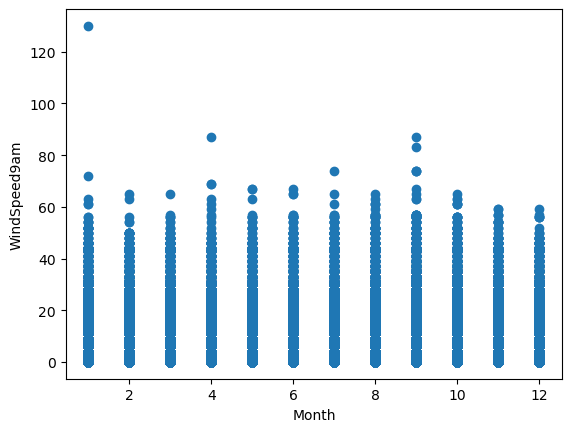

In [62]:
for feature in ["WindGustSpeed","WindSpeed3pm","WindSpeed9am"]:
    X=Aus["Month"]
    Y=Aus[feature]
    X_train=np.array(X[~ Y.isna()]).reshape(-1,1)
    Y_train=np.array(Y.dropna())
    plt.scatter(X_train.reshape(-1),Y_train)
    plt.xlabel("Month")
    plt.ylabel(str(feature))
    plt.show()

## Clear indication of Monthly Pattern, but also they seem correlated, let's have a look there

<Axes: >

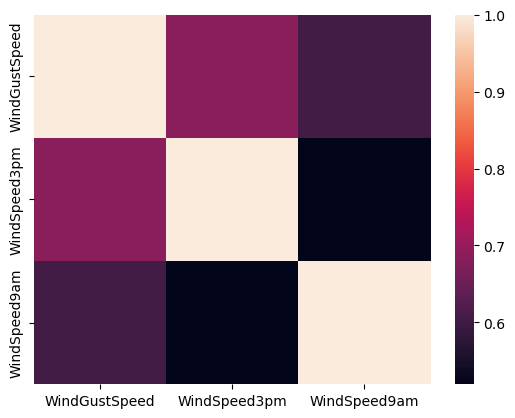

In [63]:
sns.heatmap(Aus[["WindGustSpeed","WindSpeed3pm","WindSpeed9am"]].corr())

### Again, WindSpeed3pm and WindGustSpeed seem heavily correlated, so I'll drop one 

In [64]:
Aus.drop("WindSpeed3pm",axis=1,inplace=True)

In [66]:
for feature in ["WindGustSpeed","WindSpeed9am"]:
    for month in Aus["Month"].unique():
        slc=Aus[Aus["Month"]==month][feature].copy()
        slc=slc.median()
        idx = Aus[Aus["Month"]==month].loc[:,feature].index
        Aus.loc[idx,feature] = Aus.loc[idx,feature].fillna(slc)

In [295]:
#This was used when the monthly variations were not considered
Aus["WindGustSpeed"].fillna(Aus["WindGustSpeed"].median,inplace=True)
Aus["WindSpeed3pm"].fillna(Aus["WindSpeed3pm"].median,inplace=True)
Aus["WindSpeed9am"].fillna(Aus["WindSpeed9am"].median,inplace=True)

#### Alright for the remaining columns, let me compute the correlation between seemingly common features like Humidity9am, Humidity3pm etc.

In [71]:
Aus[["Humidity9am","Humidity3pm"]].corr()#Not Very heavily Correlated

,Humidity9am,Humidity3pm
Humidity9am,1.000000,0.666949
Humidity3pm,0.666949,1.000000


In [72]:
Aus[["Pressure9am","Pressure3pm"]].corr() #Heavily Correlated, so I am dropping one

,Pressure9am,Pressure3pm
Pressure9am,1.000000,0.961326
Pressure3pm,0.961326,1.000000


In [73]:
Aus.drop("Pressure3pm",axis=1,inplace=True)

In [74]:
Aus[["Cloud9am","Cloud3pm"]].corr() #Not very heavily Correlated 

,Cloud9am,Cloud3pm
Cloud9am,1.000000,0.603564
Cloud3pm,0.603564,1.000000


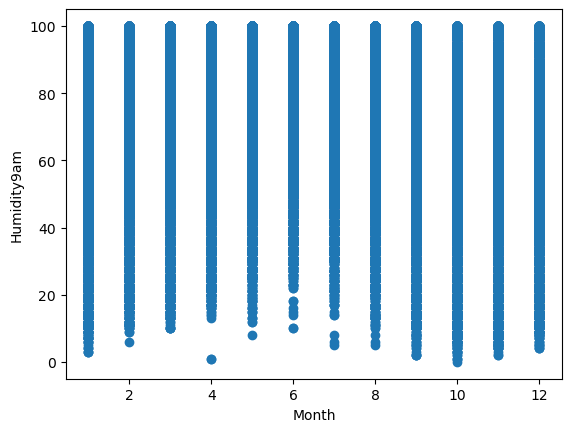

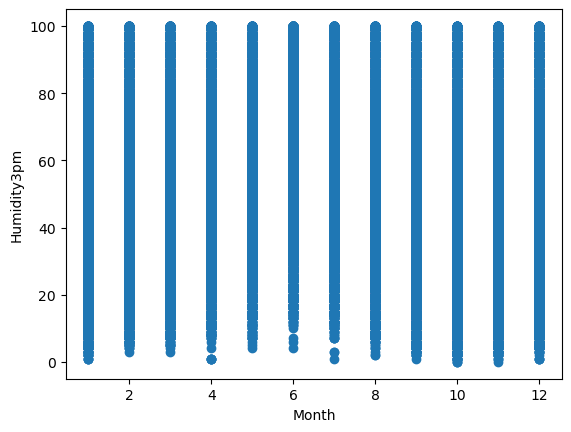

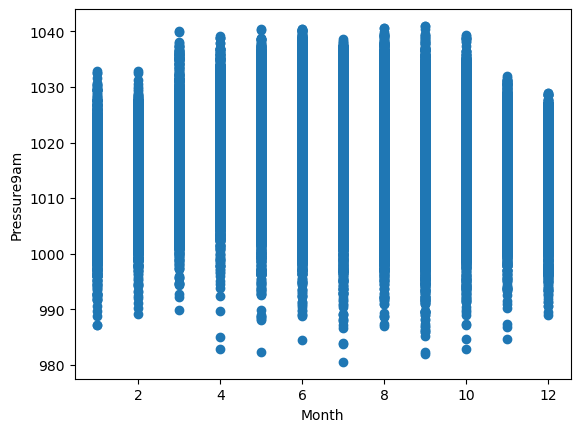

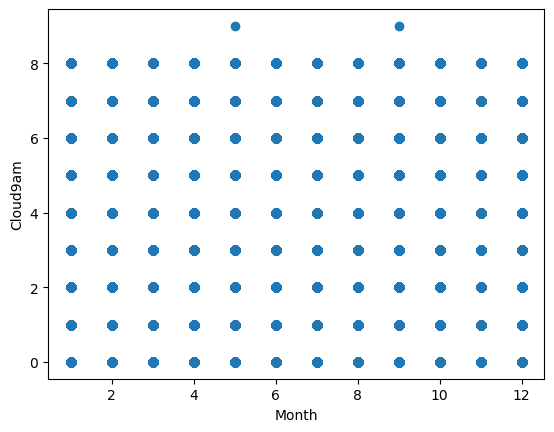

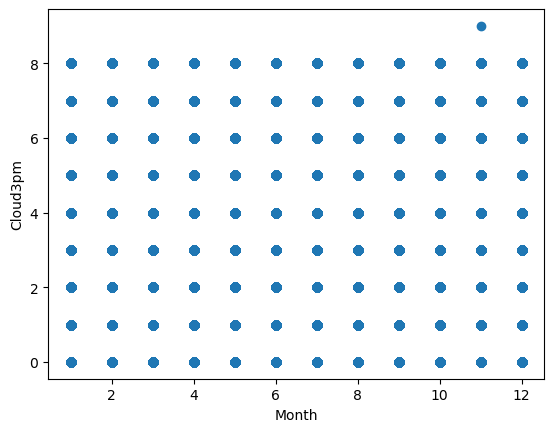

In [75]:
# And similarily the other columns
cols =["Humidity9am","Humidity3pm","Pressure9am","Cloud9am","Cloud3pm"]
for feature in cols:
    X=Aus["Month"]
    Y=Aus[feature]
    X_train=np.array(X[~ Y.isna()]).reshape(-1,1)
    Y_train=np.array(Y.dropna())
    plt.scatter(X_train.reshape(-1),Y_train)
    plt.xlabel("Month")
    plt.ylabel(str(feature))
    plt.show()

In [76]:
#Very similar Monthly patterns
weather_cols = ["Humidity9am","Humidity3pm","Pressure9am","Cloud9am","Cloud3pm"]
for feature in weather_cols:
    for month in Aus["Month"].unique():
        slc=Aus[Aus["Month"]==month][feature].copy()
        slc=slc.median()
        idx = Aus[Aus["Month"]==month].loc[:,feature].index
        Aus.loc[idx,feature] = Aus.loc[idx,feature].fillna(slc)

### For the categorical columns, I am gonna use the same technique as before , filling the null values with value of highest frequency and I was dumb enough to forget that it is the mode of the data, or let me see if there's any monthly patterns there

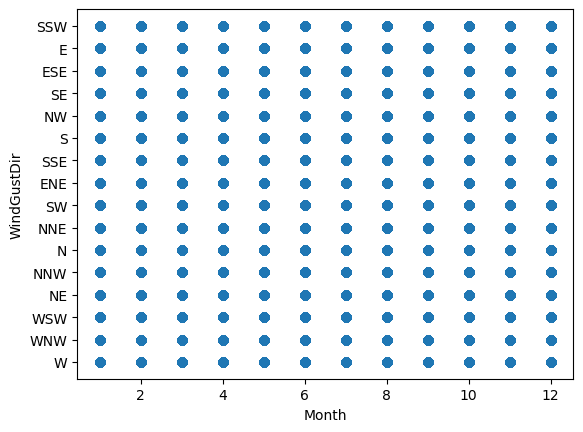

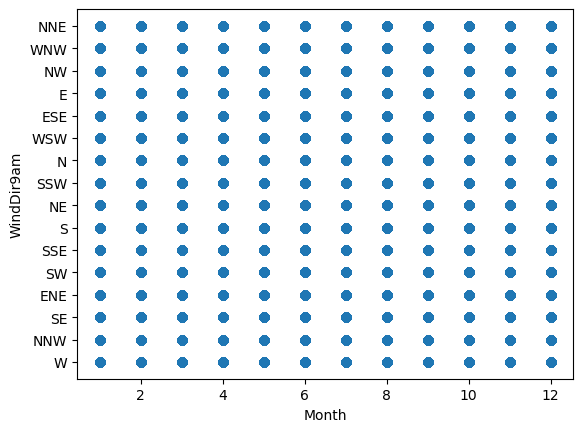

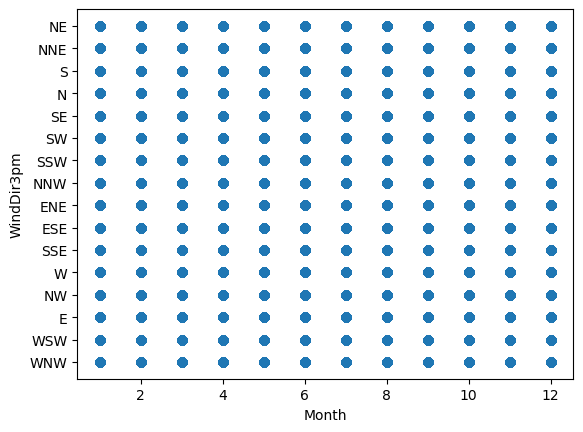

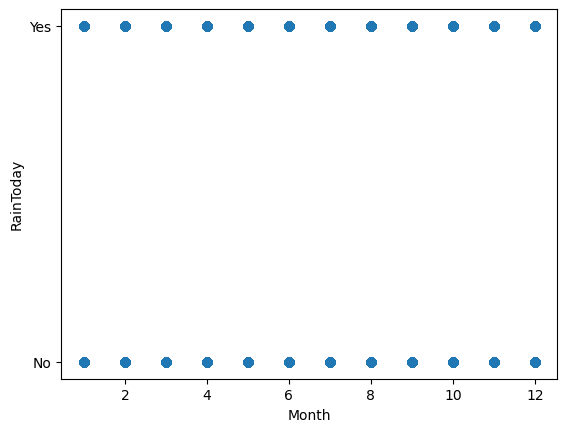

In [78]:
cols =["WindGustDir","WindDir9am","WindDir3pm","RainToday"]
for feature in cols:
    X=Aus["Month"]
    Y=Aus[feature]
    X_train=np.array(X[~ Y.isna()]).reshape(-1,1)
    Y_train=np.array(Y.dropna())
    plt.scatter(X_train.reshape(-1),Y_train)
    plt.xlabel("Month")
    plt.ylabel(str(feature))
    plt.show()
# The graphs didn't really yeild any significant patterns

In [79]:
#Not very helpful, am just replacing it with the montly mode
wind_cols = ["WindGustDir","WindDir9am","WindDir3pm","RainToday"]
for feature in wind_cols:
    for month in Aus["Month"].unique():
        slc=Aus[Aus["Month"]==month][feature].copy()
        slc=slc.mode()[0]
        idx = Aus[Aus["Month"]==month].loc[:,feature].index
        Aus.loc[idx,feature] = Aus.loc[idx,feature].fillna(slc)

In [293]:
#This was done when monthly mode wasn't used, just the mode of the entire dataset
for col in ["WindGustDir","WindDir9am","WindDir3pm","RainToday"]:
    data[col].fillna(data[col].mode()[0],inplace=True)

In [82]:
#lASTLY WE NEED TO ENCODE THE CATEGORICAL VARIABLES
for col in ["WindGustDir","WindDir9am","WindDir3pm","RainToday"]:
    column=Aus[col]
    value_mapping=dict(zip(column.unique(),range(len(column.unique()))))
    Aus[col]=pd.Series(map(lambda x:value_mapping[x],column))

In [83]:
Aus_X = Aus.drop(["Date","Location","RainTomorrow","Month","Year","Day"],axis=1)
Aus_Y =Aus["RainTomorrow"]

In [84]:
column=Aus_Y
value_mapping=dict(zip(column.unique(),range(len(column.unique()))))
Aus_Y=pd.Series(map(lambda x:value_mapping[x],column))

In [86]:
#Scaling the latitudes and the longtitudes, the other data points are pretty normalized/closer already
Aus_X_scaled = Aus_X.copy()
Aus_X_scaled["Latitude"] = (Aus_X["Latitude"] - Aus_X["Latitude"].mean())/Aus_X["Latitude"].std()
Aus_X_scaled["Longitude"] = (Aus_X["Longitude"] - Aus_X["Longitude"].mean()/Aus_X["Longitude"].std())

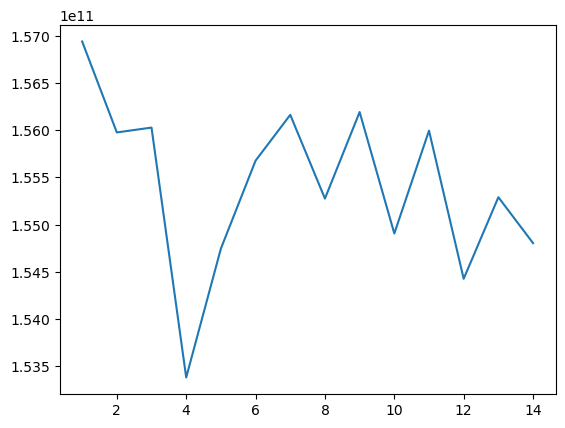

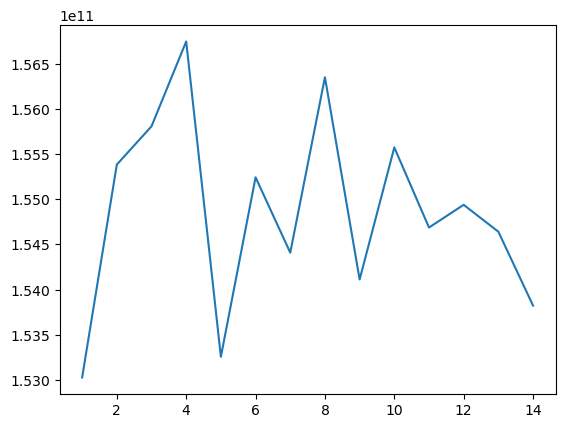

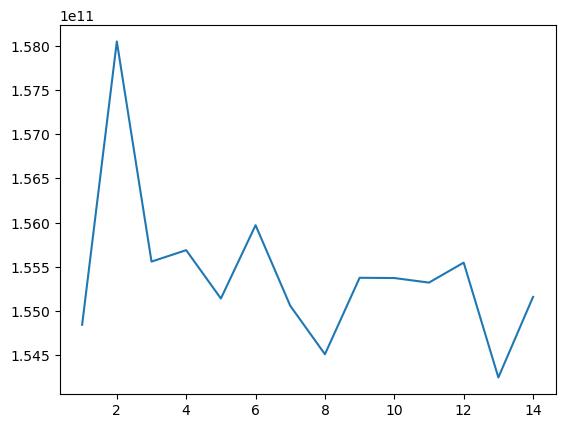

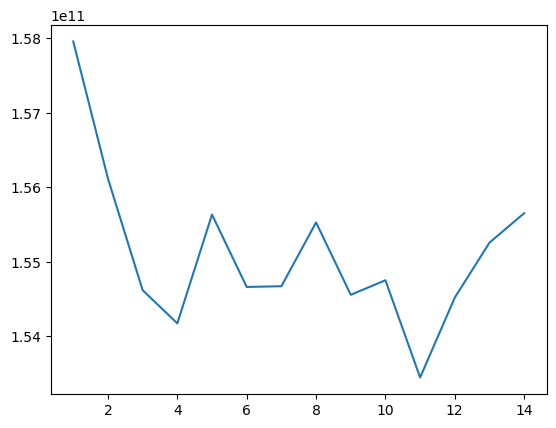

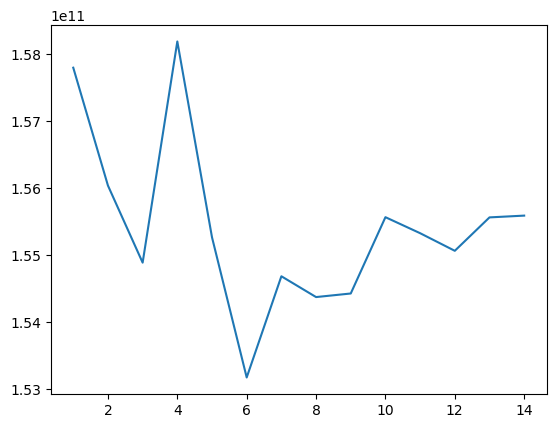

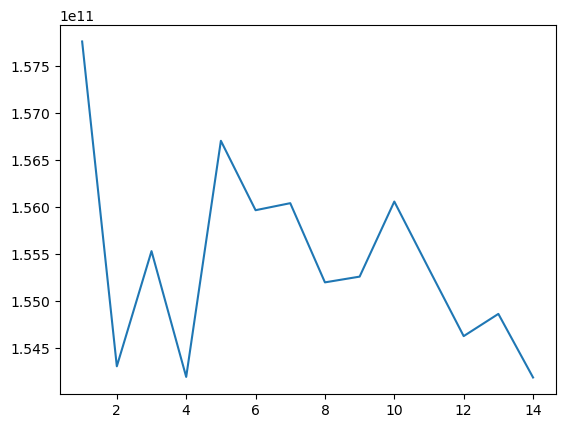

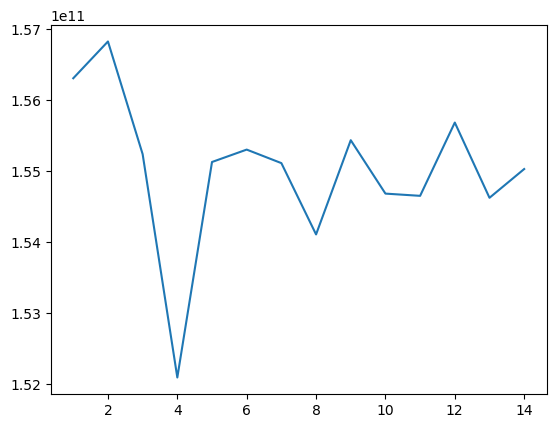

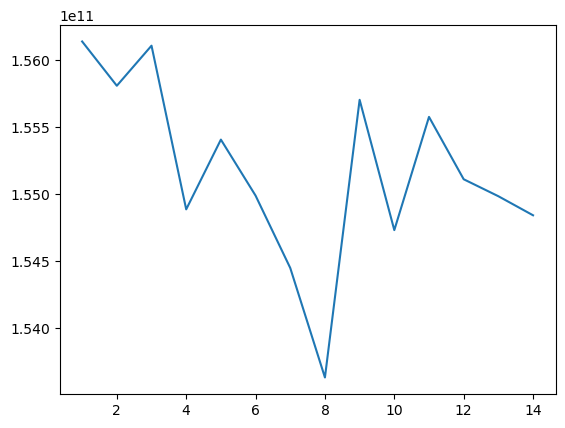

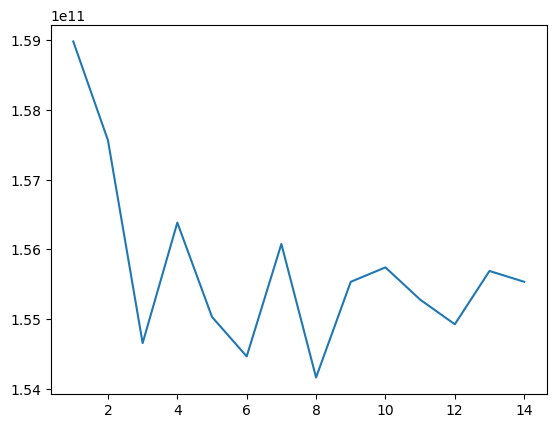

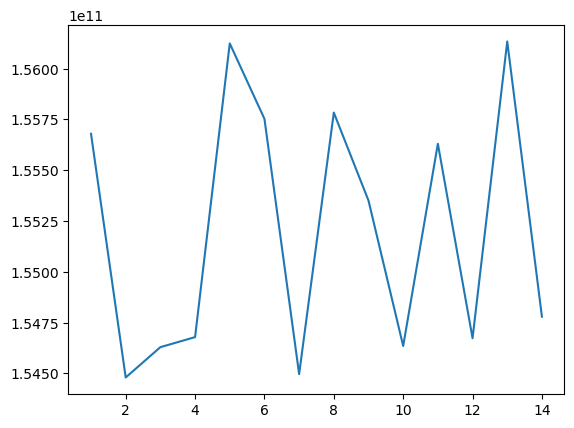

In [102]:
get_elbow(data = Aus_X_scaled,num_k=15)

#### How do you explain so many dips in the graph???????

### Based on the above curves, k-3,4,6,7,8,11 seems a good choice, let's try that

In [103]:
cluster_labels_lst = []
updated_centroids_lst = []
silhouette_score_lst = []

In [108]:
for k in [3,4,6,7,8,11]:
    centroids=init_centroids(k,Aus_X_scaled)
    cluster_labels , updated_centroids = KMeans_multiple(Aus_X_scaled,1,4,len(Aus_X_scaled.columns),centroids)
    cluster_labels_lst.append(cluster_labels)
    updated_centroids_lst.append(updated_centroids)
    silhouette_score_lst.append(silhouette_score(Aus_X_scaled,cluster_labels))
    print("Silhouette Score for K=",k,"=",silhouette_score_lst[-1])
    

Silhouette Score for K= 3 = 0.27660155671874953
Silhouette Score for K= 4 = 0.21106595582474974
Silhouette Score for K= 6 = 0.07982863290329244
Silhouette Score for K= 7 = 0.20326156064954012
Silhouette Score for K= 8 = 0.16322878246630015
Silhouette Score for K= 11 = 0.07467457700707233


### K = 3 is the best that I can do 😭😭, let's apply PCA on that and try to visualize the clusters

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [110]:
Aus_in_2d = pca.fit_transform(Aus_X_scaled)

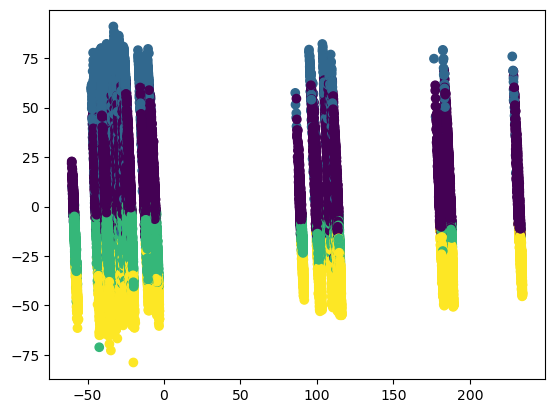

In [112]:
plt.scatter(Aus_in_2d[:,0],Aus_in_2d[:,1],c=cluster_labels_lst[0])
#plt.scatter(updated_centroids_in_2D[:,0],updated_centroids_in_2D[:,1],c='r',marker='X')

### Also, I had this idea recently that PCA is not just about visualization, it is also about reducing the number of dimensions you have, so since here we have our dataset with a bunch of features, let's apply K-Means on our dimensionally reduced data here

In [116]:
Aus_in_2d_df = pd.DataFrame(Aus_in_2d)

In [117]:
for k in [3,4,6,7,8,11]:
    centroids=init_centroids(k,Aus_in_2d_df)
    cluster_labels , updated_centroids = KMeans_multiple(Aus_in_2d_df,1,4,2,centroids)
    cluster_labels_lst.append(cluster_labels)
    updated_centroids_lst.append(updated_centroids)
    silhouette_score_lst.append(silhouette_score(Aus_in_2d_df,cluster_labels))
    print("Silhouette Score for K=",k,"=",silhouette_score_lst[-1])
    

Silhouette Score for K= 3 = 0.38367494203751906
Silhouette Score for K= 4 = 0.35635154916713735
Silhouette Score for K= 6 = 0.30710327179615127
Silhouette Score for K= 7 = 0.33109175413340125
Silhouette Score for K= 8 = 0.3642529431968699
Silhouette Score for K= 11 = 0.2503666051108864


### Pls forgive me I have really tried everything